In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import (balanced_accuracy_score, ConfusionMatrixDisplay, 
                            recall_score, precision_score, f1_score)

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTEN

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# reading the youth model dataset 
youth_model = pd.read_csv("datasets/youth_model.csv")

youth_model.head()

,hmlsmorethan1Yr,dv_neglect,dv_physical,dv_physical_rel,dv_sexual_rel,subsabuse,drugabuse,SPA
0,1,1,1,1,0,0,0,4
1,1,0,0,0,1,0,0,4
2,1,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,4


# Normal KNN Model

In [3]:
# creating our X and y

features = ['dv_neglect', 'dv_physical', 'dv_physical_rel', 'dv_sexual_rel', 'subsabuse', 'drugabuse', 'SPA']

X = youth_model[features]
y = youth_model['hmlsmorethan1Yr']

In [4]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=y)

In [5]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [6]:
# Instantiate KNN.
knn = KNeighborsClassifier()

In [7]:
cross_val_score(knn, X_train, y_train, cv = 5).mean()

0.6006734996121205

In [8]:
#let's manually tune this model
scores = []

for k in range(1, 51):
    for p in range(1, 4):
        for dist in ['uniform', 'distance']:
            knn = KNeighborsClassifier(n_neighbors=k, p = p, weights=dist)
            scores.append([k, p, dist, cross_val_score(knn, X_train, y_train, cv = 5).mean()])

In [9]:
#p is Eucledian distance
pd.DataFrame(scores, columns=['k', 'p', 'weights', 'CV score']).sort_values('CV score',
                                                                           ascending=False)

,k,p,weights,CV score
276,47,1,uniform,0.656482
294,50,1,uniform,0.655508
246,42,1,uniform,0.655025
240,41,1,uniform,0.654541
264,45,1,uniform,0.653568
...,...,...,...,...
0,1,1,uniform,0.591953
3,1,2,distance,0.591952
2,1,2,uniform,0.591952
5,1,3,distance,0.590496


In [10]:
knn_final = KNeighborsClassifier(n_neighbors= 47, p = 1, weights='uniform')

In [11]:
knn_final.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=47, p=1)

In [12]:
# train score
knn_final.score(X_train, y_train)

0.6627850557981563

In [13]:
# test score
knn_final.score(X_test, y_test)

0.6569767441860465

The model shows sign of slight overfitting with the train score being higher than the test score. 

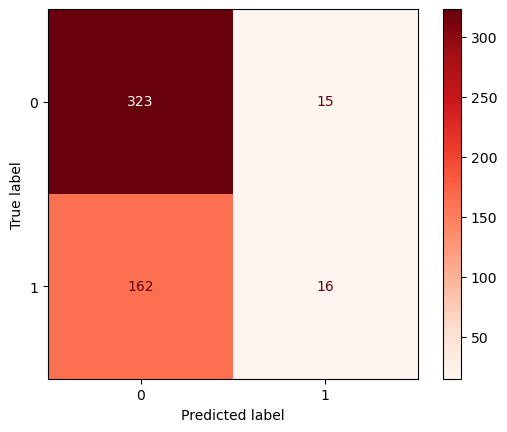

In [14]:
# Normal KNN Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn_final, X_test, y_test, cmap = 'Reds');

In [15]:
preds1 = knn_final.predict(X_test)

In [16]:
def evaluation(X_test, y_test, preds, model):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    
    b_acc = balanced_accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds, pos_label = 1)
    prec = precision_score(y_test, preds, pos_label = 1)
    f1 = f1_score(y_test, preds, pos_label = 1)

    print(f'balanced_accuracy: {b_acc}')
    print(f'recall: {recall}')
    print(f'precision: {prec}')
    print(f'f1 score: {f1}')

    return {
        'balanced_accuracy': b_acc,
        'recall': recall,
        'precision': prec,
        'f1_score': f1
    }

In [17]:
scores = []

balanced_accuracy: 0.5227544711122931
recall: 0.0898876404494382
precision: 0.5161290322580645
f1 score: 0.15311004784688995


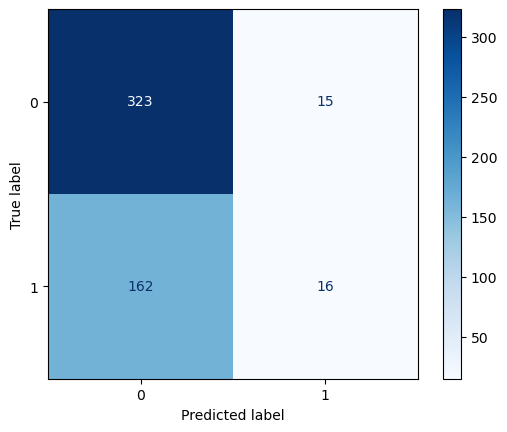

In [18]:
scores.append(evaluation(X_test, y_test, preds1, knn_final))

# Confusion Matrix of KNN Model
______

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 323 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 15 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 162 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 16 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

* For balanced accuracy, the model's overall performance in terms of correctly classifying both positive and negative cases is moderate.
* For recall, the model correctly identified approximately 9% of the youth who stayed homeless more than 1 year.
* For out of all the cases predicted as youth staying homeless more than 1 year, approximately 51% were actually true positives.
* For the F1 score, it heavily skews in identifying the negative class (youth who did not stay homeless more than 1 year).

# Oversample the minority class with Hypertuned KNN Model

In [19]:
pipe = make_pipeline(RandomOverSampler(random_state=42),
                     KNeighborsClassifier(n_neighbors= 47, p = 1, weights='uniform'))

In [20]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('randomoversampler', RandomOverSampler(random_state=42)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=47, p=1))])

In [21]:
# train score
pipe.score(X_train, y_train)

0.6259097525473072

In [22]:
# test score
pipe.score(X_test, y_test)

0.6337209302325582

The model shows signs of slight underfitting with the train score as lower than the test score. 

balanced_accuracy: 0.5621800412206636
recall: 0.33146067415730335
precision: 0.4573643410852713
f1 score: 0.38436482084690554


{'balanced_accuracy': 0.5621800412206636,
 'recall': 0.33146067415730335,
 'precision': 0.4573643410852713,
 'f1_score': 0.38436482084690554}

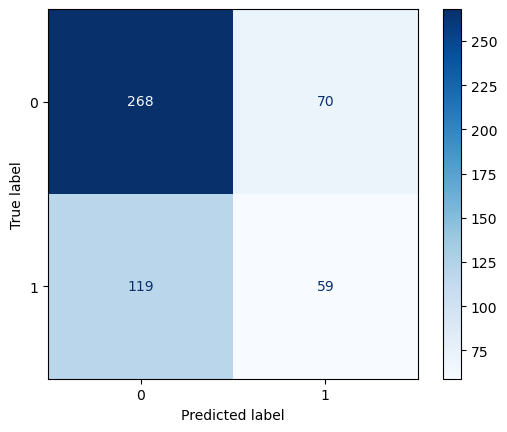

In [23]:
evaluation(X_test, y_test, pipe.predict(X_test), pipe)

# Confusion Matrix of KNN Model with RandomOverSampler
______

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 323 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 15 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 162 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 16 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

* For balanced accuracy, the model's overall performance in terms of correctly classifying both positive and negative cases is moderate.
* For recall, the model correctly identified approximately 9% of the youth who stayed homeless more than 1 year.
* For out of all the cases predicted as youth staying homeless more than 1 year, approximately 51% were actually true positives.
* For the F1 score, it heavily skews in identifying the negative class (youth who did not stay homeless more than 1 year).

# RandOverSampler with GridSearch for Hypertuned KNN

In [24]:
param_grid = {
    'randomoversampler__sampling_strategy': [.25, .5, .75, 1.0],
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],  # Number of neighbors to consider
    'kneighborsclassifier__weights': ['uniform', 'distance'],  # Weight function used in prediction
    'kneighborsclassifier__p': [1, 2]  # Power parameter for Minkowski distance metric
}

In [25]:
gs = GridSearchCV(pipe,
                 param_grid=param_grid,
                 n_jobs=-1,
                 cv=5)

In [26]:
gs.fit(X_train, y_train)

C:\Users\danie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
160 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\danie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\danie\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\danie\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 322, in fit
    Xt, yt = self._fit(X,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=47,
                                                             p=1))]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],
                         'kneighborsclassifier__p': [1, 2],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance'],
                         'randomoversampler__sampling_strategy': [0.25, 0.5,
                                                                  0.75, 1.0]})

In [27]:
# train score
gs.score(X_train, y_train)

0.6889859291606016

In [28]:
# test score
gs.score(X_test, y_test)

0.6627906976744186

The model shows sign of overfitting with the train score as higher than the test score.

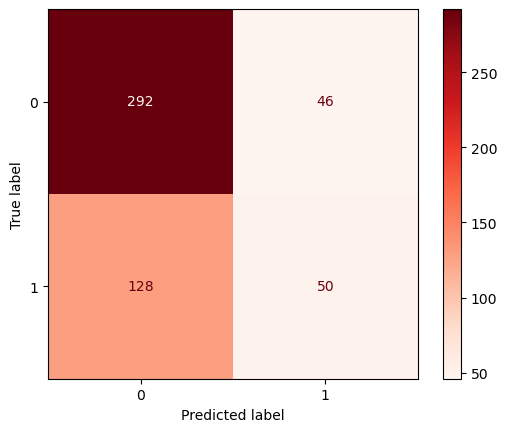

In [29]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap = 'Reds');

# Confusion Matrix of KNN with GridSearch for RandomOverSampler
______

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 292 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 46 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 128 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 50 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

# Including Balanced Accuracy with Oversample

In [30]:
gs2 = GridSearchCV(pipe,
                 param_grid=param_grid,
                 n_jobs=-1, 
                 cv=5,
                 scoring='balanced_accuracy')

In [31]:
gs2.fit(X_train, y_train)

C:\Users\danie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
160 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\danie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\danie\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\danie\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 322, in fit
    Xt, yt = self._fit(X,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=47,
                                                             p=1))]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],
                         'kneighborsclassifier__p': [1, 2],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance'],
                         'randomoversampler__sampling_strategy': [0.25, 0.5,
                                                                  0.75, 1.0]},
             scoring='balanced_accuracy')

In [32]:
# train score
gs2.score(X_train, y_train)

0.6145692809707989

In [33]:
# test score
gs2.score(X_test, y_test)

0.5763911973937903

The model shows sign of overfitting with train score as higher than the test score. 

balanced_accuracy: 0.5763911973937903
recall: 0.29775280898876405
precision: 0.5196078431372549
f1 score: 0.37857142857142856


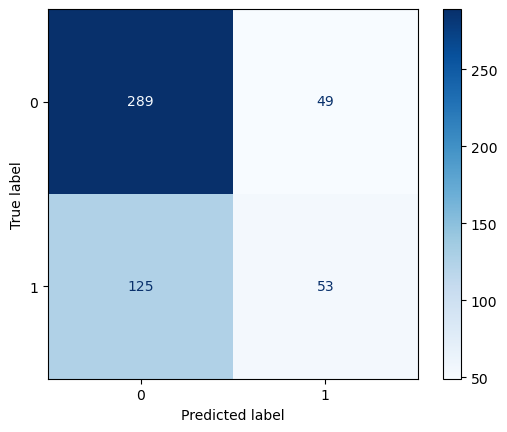

In [34]:
# making prediction
preds2 = gs2.predict(X_test)

# evaluating the model

scores.append(evaluation(X_test, y_test, preds2, gs2))

# Confusion Matrix of KNN with GridSearch and Balanced Accuracy for RandomOverSampler
______

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 289 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 49 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 125 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 53 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

* For balanced accuracy, the model's overall performance in terms of correctly classifying both positive and negative cases is moderate.
* For recall, the model correctly identified approximately 30% of the youth who stayed homeless more than 1 year.
* For out of all the cases predicted as youth staying homeless more than 1 year, approximately 52% were actually true positives.
* For the F1 score, it heavily skews in identifying the negative class (youth who did not stay homeless more than 1 year).

In [35]:
pd.DataFrame(scores, index=['knn', 'RandomOverSampler'])

,balanced_accuracy,recall,precision,f1_score
knn,0.522754,0.089888,0.516129,0.153110
RandomOverSampler,0.576391,0.297753,0.519608,0.378571


# SMOTEN Method with Hypertuned KNN Model

In [36]:
pipe3 = make_pipeline(SMOTEN(random_state=42), KNeighborsClassifier(n_neighbors= 47, p = 1, weights='uniform'))

pipe3

Pipeline(steps=[('smoten', SMOTEN(random_state=42)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=47, p=1))])

In [37]:
param_grid3 = {
    'smoten__k_neighbors' : [3, 5, 7],
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],  # Number of neighbors to consider
    'kneighborsclassifier__weights': ['uniform', 'distance'],  # Weight function used in prediction
    'kneighborsclassifier__p': [1, 2]  # Power parameter for Minkowski distance metric
}

In [38]:
gs3 = GridSearchCV(pipe3,
                 param_grid=param_grid3,
                 cv=5,
                 scoring='balanced_accuracy')

In [39]:
gs3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smoten', SMOTEN(random_state=42)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=47,
                                                             p=1))]),
             param_grid={'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],
                         'kneighborsclassifier__p': [1, 2],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance'],
                         'smoten__k_neighbors': [3, 5, 7]},
             scoring='balanced_accuracy')

In [40]:
# train score
gs3.score(X_train, y_train)

0.6083078783582323

In [41]:
# test score
gs3.score(X_test, y_test)

0.5713715843361479

The model shows sign of overfitting with train score as higher than its test score.

balanced_accuracy: 0.5713715843361479
recall: 0.2640449438202247
precision: 0.5340909090909091
f1 score: 0.3533834586466165


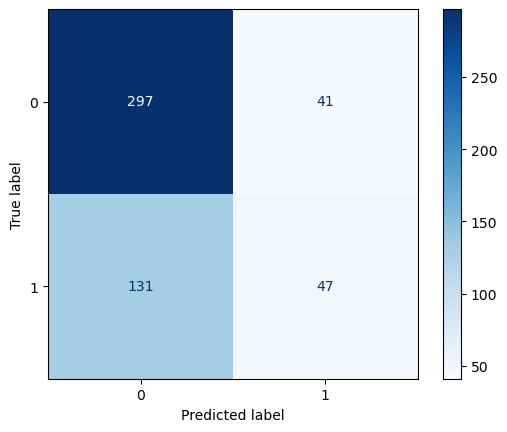

In [42]:
# create prediction
preds3 = gs3.predict(X_test)

# find out respective scores
scores.append(evaluation(X_test, y_test, preds3, gs3))

# Confusion Matrix of Hypertuned KNN with SMOTEN
______

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 297 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 41 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 131 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 47 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

* For balanced accuracy, the model's overall performance in terms of correctly classifying both positive and negative cases is moderate.
* For recall, the model correctly identified approximately 26% of the youth who stayed homeless more than 1 year.
* For out of all the cases predicted as youth staying homeless more than 1 year, approximately 53% were actually true positives.
* For the F1 score, it heavily skews in identifying the negative class (youth who did not stay homeless more than 1 year).

In [43]:
pd.DataFrame(scores, index=['knn', 'RamdomOverSampler', 'SMOTEN'])

,balanced_accuracy,recall,precision,f1_score
knn,0.522754,0.089888,0.516129,0.153110
RamdomOverSampler,0.576391,0.297753,0.519608,0.378571
SMOTEN,0.571372,0.264045,0.534091,0.353383


# ADASYN with Hypertuned KNN

In [44]:
pipe4 = make_pipeline(ADASYN(random_state=42),
                    KNeighborsClassifier(n_neighbors= 47, p = 1, weights='uniform'))

In [45]:
param_grid4 = {
    'adasyn__n_neighbors':[3,5,7],
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],  # Number of neighbors to consider
    'kneighborsclassifier__weights': ['uniform', 'distance'],  # Weight function used in prediction
    'kneighborsclassifier__p': [1, 2]  # Power parameter for Minkowski distance metric
}

In [46]:
gs4 = GridSearchCV(
    pipe4, 
    param_grid=param_grid4,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1
)

In [47]:
gs4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('adasyn', ADASYN(random_state=42)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=47,
                                                             p=1))]),
             n_jobs=-1,
             param_grid={'adasyn__n_neighbors': [3, 5, 7],
                         'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],
                         'kneighborsclassifier__p': [1, 2],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             scoring='balanced_accuracy')

In [48]:
# train score
gs4.score(X_train, y_train)

0.5988037030472994

In [49]:
# test score
gs4.score(X_test, y_test)

0.5596868559271325

The mdoel shows signs of overfitting with train score higher than its test score.

balanced_accuracy: 0.5596868559271325
recall: 0.25842696629213485
precision: 0.4946236559139785
f1 score: 0.3394833948339484


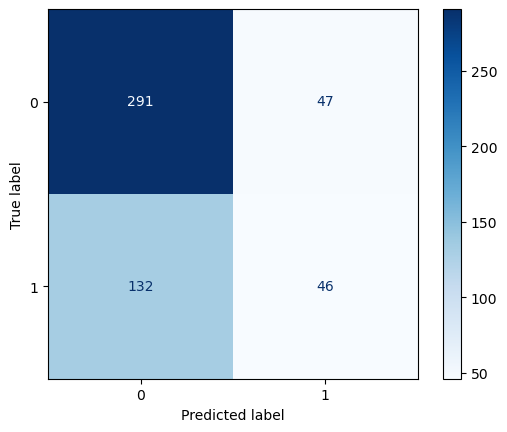

In [50]:
preds4 = gs4.predict(X_test)

scores.append(evaluation(X_test, y_test, preds4, gs4))

# Confusion Matrix of Hypertuned KNN with ADASYN
______

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 291 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 47 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 132 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 46 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

* For balanced accuracy, the model's overall performance in terms of correctly classifying both positive and negative cases is moderate.
* For recall, the model correctly identified approximately 26% of the youth who stayed homeless more than 1 year.
* For out of all the cases predicted as youth staying homeless more than 1 year, approximately 49% were actually true positives.
* For the F1 score, it heavily skews in identifying the negative class (youth who did not stay homeless more than 1 year).

In [51]:
pd.DataFrame(scores, index = ['knn', 'RandomOverSampler',
                             'SMOTEN', 'ADASYN'])

,balanced_accuracy,recall,precision,f1_score
knn,0.522754,0.089888,0.516129,0.153110
RandomOverSampler,0.576391,0.297753,0.519608,0.378571
SMOTEN,0.571372,0.264045,0.534091,0.353383
ADASYN,0.559687,0.258427,0.494624,0.339483


## Overweighing minority class importance in algorithms
_____

since we don't have class_weight with KNN model, we will use weight as the main parameter to overweigh: 'distance': weight points by the inverse of their distance. 

In [52]:
knn5 = KNeighborsClassifier(n_neighbors= 47, p = 1, weights='distance')

knn5.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=47, p=1, weights='distance')

In [53]:
# train score
knn5.score(X_train, y_train)

0.710334788937409

In [54]:
# test score
knn5.score(X_test, y_test)

0.6608527131782945

The model shows sign of overfitting with the train score as higher than its test score.

balanced_accuracy: 0.5390100392261152
recall: 0.14606741573033707
precision: 0.5306122448979592
f1 score: 0.22907488986784139


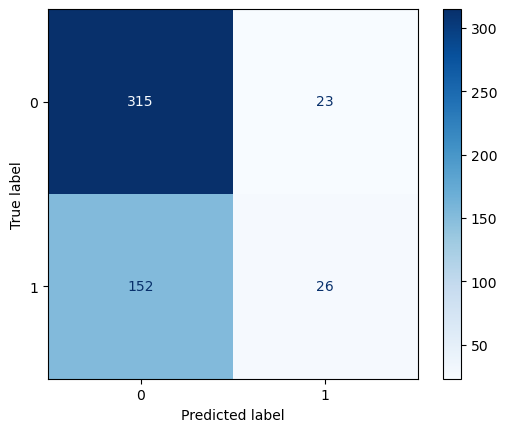

In [55]:
scores.append(evaluation(X_test, y_test, knn5.predict(X_test), knn5))

# Confusion Matrix of Hypertuned KNN with Overweighing
______

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 315 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 23 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 152 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 26 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

* For balanced accuracy, the model's overall performance in terms of correctly classifying both positive and negative cases is moderate.
* For recall, the model correctly identified approximately 14% of the youth who stayed homeless more than 1 year.
* For out of all the cases predicted as youth staying homeless more than 1 year, approximately 53% were actually true positives.
* For the F1 score, it heavily skews in identifying the negative class (youth who did not stay homeless more than 1 year).

In [56]:
pd.DataFrame(scores, index=['knn', 'RandomOverSampler', 'SMOTEN', 'ADASYN', 'Weightedknn'])

,balanced_accuracy,recall,precision,f1_score
knn,0.522754,0.089888,0.516129,0.153110
RandomOverSampler,0.576391,0.297753,0.519608,0.378571
SMOTEN,0.571372,0.264045,0.534091,0.353383
ADASYN,0.559687,0.258427,0.494624,0.339483
Weightedknn,0.539010,0.146067,0.530612,0.229075
